#                                                                             2018015027 정보통계학과 김한탁

# 1. Loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# 2. Loading the dataset

In [2]:
df = pd.read_csv('cancer.csv')
df.head()

,Id,Clump_thickness,Uniformity_Cell_Size,Uniformity_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [3]:
df.shape

(699, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Id                           699 non-null    int64 
 1   Clump_thickness              699 non-null    int64 
 2   Uniformity_Cell_Size         699 non-null    int64 
 3   Uniformity_Cell_Shape        699 non-null    int64 
 4   Marginal_Adhesion            699 non-null    int64 
 5   Single_Epithelial_Cell_Size  699 non-null    int64 
 6   Bare_Nuclei                  699 non-null    object
 7   Bland_Chromatin              699 non-null    int64 
 8   Normal_Nucleoli              699 non-null    int64 
 9   Mitoses                      699 non-null    int64 
 10  Class                        699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


### 2.1 Data information
cancer.csv는 총 13개의 컬럼이 있으며, 683개의 데이터로 이루어져 있음.

1. Id : id번호
2. Clump_thickness: 덩어리 두께
3. Uniformity_Cell_Size : 암세포 크기
4. Uniformity_Cell_Shape : 세포 모양
5. Marginal_Adhesion : 한계
6. Single_Epithelial_Cell_Size : 상피세포크기
7. Bare_Nuclei : 베어핵, 베어핵의 정도를 순서척도로 나타낸 것으로 보임.
8. Bland_Chromatin : 염색질
9. Normal_Nucleoli: 정상세포
10. Mitoses : 유사분열
11. Class : 양성, 음성

# 3. Data Visualization & Exploratory data analysis: Data Information

### 3.1 결측치 확인 

결측치는 없음

In [5]:
df.isna().sum()

Id                             0
Clump_thickness                0
Uniformity_Cell_Size           0
Uniformity_Cell_Shape          0
Marginal_Adhesion              0
Single_Epithelial_Cell_Size    0
Bare_Nuclei                    0
Bland_Chromatin                0
Normal_Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64

### 3.2 이상치 확인

다음은 수치형 자료형인 컬럼들의 boxplot이다.  
이상치가 Marginal_Adhesion, Single_Epithelial_Cell_size, Bland_Chromatin, Normal_Nucleoli, Mitoses의 컬럼에서 발견되었다.  Mitoses 컬럼을 제외한 나머지 컬럼들의 이상치는 개수도 적고, 값도 크게 벗어나지 않는다고 생각하여 정상적인 값으로 고려될 수 있다고 생각된다.   
그러나 Mitoses의 이상치들은 일반적인 값들과 확연히 차이나는 것으로 생각되어, 제거를 고려할 필요가 있다.

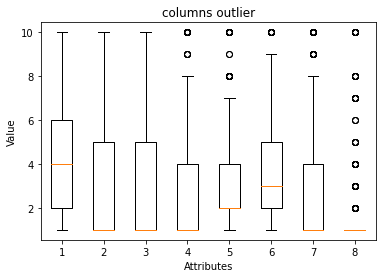

In [6]:
# 3. Exploratory data analysis: Outliers?
data_to_boxplot = [df['Clump_thickness'],
                   df['Uniformity_Cell_Size'],
                   df['Uniformity_Cell_Shape'],
                   df['Marginal_Adhesion'],
                   df['Single_Epithelial_Cell_Size'],
                   df['Bland_Chromatin'],
                   df['Normal_Nucleoli'],
                   df['Mitoses']]
plt.boxplot(data_to_boxplot)
plt.title('columns outlier')
plt.xlabel('Attributes')
plt.ylabel('Value')
plt.show()

### 3.3 특정 칼럼 확인

Bare_Nuclei 컬럼은 bare 핵의 정도를 순서척도로 나타낸 것으로, 정도에 따라 숫자의 크기로 표현되었음을 알 수 있다.   
따라서 object형이 아닌 int형으로 변환하여, 상관관계를 파악하는 것이 적절하다고 판단하고, Bare_Nuclei의 자료형 변환을 고려하였다.

In [7]:
df['Bare_Nuclei'].unique()

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'],
      dtype=object)

Bare_Nuclei 컬럼의 unique한 값들 중 순서척도가 아닌 '?'값이 발견되었고, 이것을 제거한 뒤 자료형을 변환하는 것이 적절하다고 생각된다.

In [8]:
df=df.drop(df[df['Bare_Nuclei']=="?"].index)
df['Bare_Nuclei'].unique()

array(['1', '10', '2', '4', '3', '9', '7', '5', '8', '6'], dtype=object)

In [9]:
df['Bare_Nuclei']=df['Bare_Nuclei'].astype('int')

### 3.4 컬럼 간 상관관계 확인

다음은 컬럼 간의 상관관계 heatmap이다.
heatmap을 통해 target과 각각의 컬럼들간의 상관계수를 확인하여 상관관계가 낮은 컬럼들을 제거할 수 있으며, 추가적으로 target을 제외한 컬럼들 간의 상관계수를 통해 다중공선성이 높은(상관계수가 큰) 변수를 제거하여 모델의 성능을 높이는데 도움을 줄 수 있다.  
target과의 상관계수를 확인했을 때, Id와 Mitoses 컬럼을 제외한 대부분의 컬럼이 0.7이상의 상관계수를 나타냄을 알 수 있다.  
따라서 Id, Mitoses 컬럼은 제거하는 것이 바람직하다고 생각되며, 다중공선성을 해소를 위해 상관계수가 0.91로 매우 높은 Uniformity_Cell_Size, Uniformity_Cell_Shape 중 하나의 컬럼을 제거하는 것이 고려될 수 있다.

Text(0.5, 1.0, 'correlation heatmap')

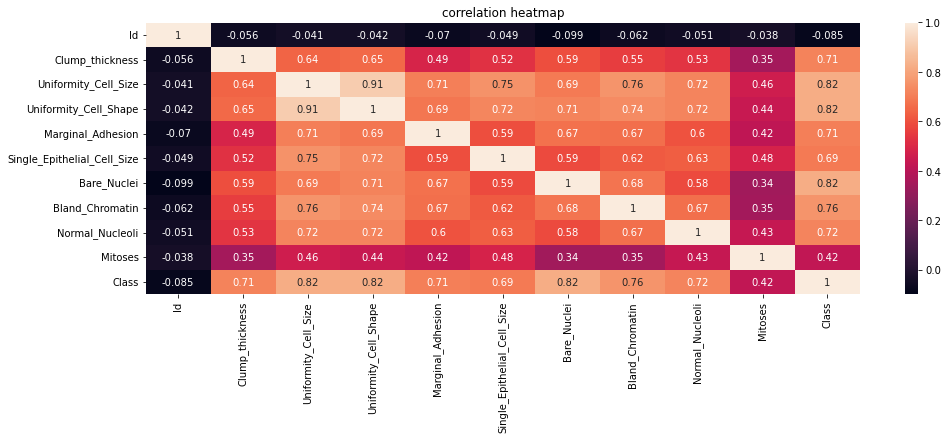

In [10]:
dfcorr = df.corr()
plt.figure(figsize=(16,5))
sns.heatmap(data = dfcorr, annot=True)
plt.title('correlation heatmap')

### 3.5 target(class)의 비율 

target이 범주형일 때, 비율을 살펴보는 것은 의미가 있다.
target 중 한개의 값의 비율이 압도적으로 크다면, 모델 학습과 예측이 무의미해질 수 있기 때문이다.
따라서 target의 값은 적절한 비율로 나타나는 것이 바람직하며, 비율이 불균형할 경우 학습에 사용할 데이터에 대해 과소표잡이나 과대표집등의 방법을 사용하는 것이 적절하다고 생각된다.

In [11]:
df['Class'].unique()

array([2, 4], dtype=int64)

In [12]:
print(df['Class'].value_counts())
print()
print(df['Class'].value_counts()/np.float64(len(df)))

2    444
4    239
Name: Class, dtype: int64

2    0.650073
4    0.349927
Name: Class, dtype: float64


target의 값 '2', '4'이 약 6.5:3.5의 비율로 학습에 사용하기에 전체데이터를 사용해도 크게 문제되지 않을 것으로 생각된다.

### 3.6 Data preprocessing(결론)

#### 1. 특정 컬럼의 이상값 제거 (3.3) -> 7
= Bare_Nuclei의 이상값 제거 및 자료형 변환

#### 2. 불필요한 컬럼 제거 -> 7.1
= Id, MItose 컬럼 제거

# 4. Split data into separate training and test set

training, test data의 비율은 8:2로 나누었다.

In [13]:
training_points = df.drop(columns=['Class'])
training_labels = df['Class']

X_train, X_test, y_train, y_test = train_test_split(training_points,
                                                    training_labels,
                                                    test_size=0.2,
                                                    random_state=4)

# 5. Training model(Fit K Neighbours Classifier)

다음은 K Neighbors Clasifier 모델을 학습시키고, test data(X_test)에 대해 Target을 예측하는 과정이다.  
데이터가 속한 군집을 분류하기 위해 고려할 데이터(n_neighbors)를 1개로 설정하였으며, guesses는 X_test에 대한 target의 예측 값을 나타낸다.

In [14]:
classifier = KNeighborsClassifier(n_neighbors = 1)
classifier.fit(X_train, y_train)
guesses = classifier.predict(X_test)
print(guesses)

[2 4 2 4 4 2 4 2 2 2 2 2 4 2 4 2 2 2 2 2 4 4 2 4 2 2 2 2 2 4 2 4 4 2 2 2 4
 2 2 2 2 4 2 2 4 2 2 2 4 4 2 2 2 4 4 2 2 2 2 2 2 4 2 2 4 2 2 2 2 2 2 2 4 2
 2 2 2 4 4 2 2 2 2 4 4 4 2 4 2 2 2 2 2 2 4 4 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2
 2 4 4 4 2 2 2 2 2 2 2 4 4 2 2 4 2 2 2 2 2 2 2 2 4 2]


# 6. Checking out Accuracy

모델의 학습 성능을 판단하기 위한 평가 지표는 Acurracy를 사용하였다.  
Accuracy는 모델이 test 데이터의 실제 target과 예측 target 간의 정답의 수를 통해 계산되며, 올바른 예측 target / 전체 target 수로 표현된다.  
아래의 경우 전체 예측된 타겟 137개 중 70개, 18개가 '2', '4'를 정확하게 예측하였음을 알 수 있다.  
따라서 Acurracy는 98/137=0.6423357664233577로 나타났다.

In [15]:
print(confusion_matrix(y_test, guesses))
print('Acurracy : ', metrics.accuracy_score(y_test, guesses))

[[70 20]
 [29 18]]
Acurracy :  0.6423357664233577


# 7. Improving Accuracy: Tuning k parameter 

다음은 데이터가 속한 군집을 분류하기 위해 고려할 데이터(n_neighbors) 수에 따른 Acurracy의 변화로, 1 ~ 50의 범위를 고려한 결과이다. n_neighbors가 12 ~ 14의 경우에, Acurracy가 약 0.693로 가장 높게 나타났음을 알 수 있다.

[0.642, 0.635, 0.606, 0.657, 0.635, 0.628, 0.642, 0.65, 0.686, 0.672, 0.672, 0.693, 0.693, 0.693, 0.686, 0.686, 0.65, 0.657, 0.642, 0.664, 0.657, 0.679, 0.664, 0.664, 0.664, 0.686, 0.65, 0.657, 0.664, 0.664, 0.65, 0.657, 0.62, 0.65, 0.628, 0.672, 0.664, 0.657, 0.679, 0.679, 0.664, 0.672, 0.679, 0.679, 0.664, 0.664, 0.672, 0.672, 0.672]


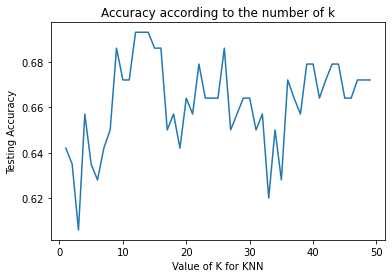

In [16]:
k_range = range(1, 50)

accuracy_scores = []

for k in k_range:
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(X_train, y_train)
    guesses = classifier.predict(X_test)
    accuracy_scores.append(metrics.accuracy_score(y_test, guesses).round(3))
print(accuracy_scores)

plt.plot(k_range, accuracy_scores)
plt.title('Accuracy according to the number of k')
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.show()

# 7.1 Improving Accuracy : 불필요한 컬럼제거

3.4의 상관계수 heatmap에서 target과 Id, Mitoses 컬럼이 각각 낮은 상관계수(약 -0.085, 약 0.43)를 갖는 것을 알 수 있었다.  
따라서 모델의 성능 향상을 위해 Id, Mitoses 컬럼을 training data에서 제거하기로 하였다.

### 7.1.1 Split data into separate training and test set

불필요한 컬럼 제거(Id, MItose 컬럼 제거)

In [17]:
training_points = df.drop(columns=['Class', 'Id', 'Mitoses'])
training_labels = df['Class']

X_train, X_test, y_train, y_test = train_test_split(training_points,
                                                    training_labels,
                                                    test_size=0.2,
                                                    random_state=4)

### 7.1.2 Training model(Fit K Neighbours Classifier)

In [18]:
classifier = KNeighborsClassifier(n_neighbors = 1)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

### 7.1.3 Checking out Accuracy

다음은 Id, Mitoses를 제거한 데이터셋을 학습한 모델의 Acurracy를 나타내는 그래프이다.
기존의 최대 Acurracy값인 약 0.693보다 확연히 높아진 Acurracy들을 확인할 수 있으며, n_neighbors가 22 ~ 44의 경우에, Acurracy가 약 0.985로 가장 높게 나타났음을 알 수 있다.

[0.978, 0.964, 0.971, 0.971, 0.971, 0.978, 0.971, 0.978, 0.964, 0.971, 0.964, 0.964, 0.964, 0.971, 0.964, 0.971, 0.964, 0.978, 0.971, 0.978, 0.978, 0.985, 0.985, 0.985, 0.985, 0.985, 0.985, 0.985, 0.985, 0.985, 0.985, 0.985, 0.985, 0.985, 0.985, 0.985, 0.985, 0.985, 0.985, 0.985, 0.985, 0.985, 0.985, 0.978, 0.978, 0.978, 0.978, 0.978, 0.978]


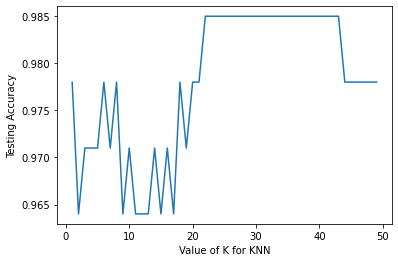

In [19]:
 k_range = range(1, 50)

accuracy_scores = []

for k in k_range:
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(X_train, y_train)
    guesses = classifier.predict(X_test)
    accuracy_scores.append(metrics.accuracy_score(y_test, guesses).round(3))
print(accuracy_scores)

plt.plot(k_range, accuracy_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.show()